## 1. Імпорт бібліотек та завантаження датасету

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import urllib.request

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.2
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Завантаження реального датасету Multi-class Weather Dataset
# Датасет містить ~1100 зображень у 4 класах: cloudy, rain, shine, sunrise

import shutil
from sklearn.model_selection import train_test_split as sklearn_train_test_split
import glob

dataset_path = "weather_dataset_real"
raw_dataset_path = "weather_raw"

# Завантажуємо датасет з Kaggle через kagglehub
if not os.path.exists(dataset_path):
    print("Завантаження реального датасету Multi-class Weather Dataset...")
    
    try:
        # Спроба 1: через kagglehub
        import kagglehub
        path = kagglehub.dataset_download("pratik2901/multiclass-weather-dataset")
        print(f"Датасет завантажено: {path}")
        raw_dataset_path = path
    except ImportError:
        print("kagglehub не встановлено. Встановлюємо...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'kagglehub', '-q'])
        import kagglehub
        path = kagglehub.dataset_download("pratik2901/multiclass-weather-dataset")
        print(f"Датасет завантажено: {path}")
        raw_dataset_path = path
    except Exception as e:
        print(f"Помилка завантаження через kagglehub: {e}")
        print("Спробуйте завантажити вручну з:")
        print("https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset")
        raise
    
    # Знаходимо папку з даними (може бути вкладена)
    # Шукаємо папку, що містить класи погоди
    possible_paths = [
        raw_dataset_path,
        os.path.join(raw_dataset_path, "Multi-class Weather Dataset"),
        os.path.join(raw_dataset_path, "dataset"),
    ]
    
    source_path = None
    for p in possible_paths:
        if os.path.exists(p):
            subdirs = os.listdir(p)
            if any(d.lower() in ['cloudy', 'rain', 'shine', 'sunrise', 'dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rainbow', 'rime', 'sandstorm', 'snow'] for d in subdirs):
                source_path = p
                break
    
    if source_path is None:
        # Пошук рекурсивно
        for root, dirs, files in os.walk(raw_dataset_path):
            if any(d.lower() in ['cloudy', 'rain', 'shine', 'sunrise'] for d in dirs):
                source_path = root
                break
    
    if source_path is None:
        print(f"Структура завантаженого датасету: {os.listdir(raw_dataset_path)}")
        raise ValueError("Не вдалося знайти папки з класами погоди")
    
    print(f"Джерело даних: {source_path}")
    print(f"Знайдені класи: {os.listdir(source_path)}")
    
    # Створюємо структуру train/test
    os.makedirs(f"{dataset_path}/train", exist_ok=True)
    os.makedirs(f"{dataset_path}/test", exist_ok=True)
    
    # Обираємо класи для використання (ті, що є в датасеті)
    available_classes = os.listdir(source_path)
    # Фільтруємо тільки потрібні класи (cloudy, rain, shine, sunrise або інші доступні)
    target_classes = ['cloudy', 'rain', 'shine', 'sunrise']
    classes_to_use = [c for c in available_classes if c.lower() in [tc.lower() for tc in target_classes]]
    
    # Якщо немає стандартних класів, беремо перші 4 доступні
    if len(classes_to_use) < 4:
        classes_to_use = [c for c in available_classes if os.path.isdir(os.path.join(source_path, c))][:4]
    
    print(f"Використовуємо класи: {classes_to_use}")
    
    for weather_class in classes_to_use:
        class_path = os.path.join(source_path, weather_class)
        if not os.path.isdir(class_path):
            continue
            
        # Отримуємо всі зображення
        images = glob.glob(os.path.join(class_path, "*.[jJ][pP][gG]")) + \
                 glob.glob(os.path.join(class_path, "*.[pP][nN][gG]")) + \
                 glob.glob(os.path.join(class_path, "*.[jJ][pP][eE][gG]"))
        
        if len(images) == 0:
            print(f"  {weather_class}: немає зображень, пропускаємо")
            continue
        
        # Розділяємо на train/test (80/20)
        train_imgs, test_imgs = sklearn_train_test_split(images, test_size=0.2, random_state=42)
        
        # Створюємо папки
        os.makedirs(f"{dataset_path}/train/{weather_class.lower()}", exist_ok=True)
        os.makedirs(f"{dataset_path}/test/{weather_class.lower()}", exist_ok=True)
        
        # Копіюємо зображення
        for img in train_imgs:
            shutil.copy(img, f"{dataset_path}/train/{weather_class.lower()}/")
        for img in test_imgs:
            shutil.copy(img, f"{dataset_path}/test/{weather_class.lower()}/")
        
        print(f"  {weather_class}: {len(train_imgs)} train, {len(test_imgs)} test")
    
    print("\nДатасет підготовлено!")
else:
    print("Датасет вже існує.")

# Перевірка структури датасету
print("\n=== Структура датасету ===")
for split in ['train', 'test']:
    split_path = f"{dataset_path}/{split}"
    if os.path.exists(split_path):
        print(f"\n{split.upper()}:")
        for weather in sorted(os.listdir(split_path)):
            class_path = f"{split_path}/{weather}"
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                print(f"  {weather}: {count} зображень")

Завантаження датасету...
Датасет згенеровано!

TRAIN:
  cloudy: 150 зображень
  rain: 150 зображень
  shine: 150 зображень
  sunrise: 150 зображень

TEST:
  cloudy: 30 зображень
  rain: 30 зображень
  shine: 30 зображень
  sunrise: 30 зображень


## 2. Підготовка даних та аугментація

In [3]:
# Параметри
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Аугментація для тренувальних даних
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% для валідації
)

# Тестові дані тільки нормалізуємо
test_datagen = ImageDataGenerator(rescale=1./255)

# Генератори даних
train_generator = train_datagen.flow_from_directory(
    f"{dataset_path}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    f"{dataset_path}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    f"{dataset_path}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Класи
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"\nКласи: {class_names}")
print(f"Кількість класів: {num_classes}")

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 120 images belonging to 4 classes.

Класи: ['cloudy', 'rain', 'shine', 'sunrise']
Кількість класів: 4


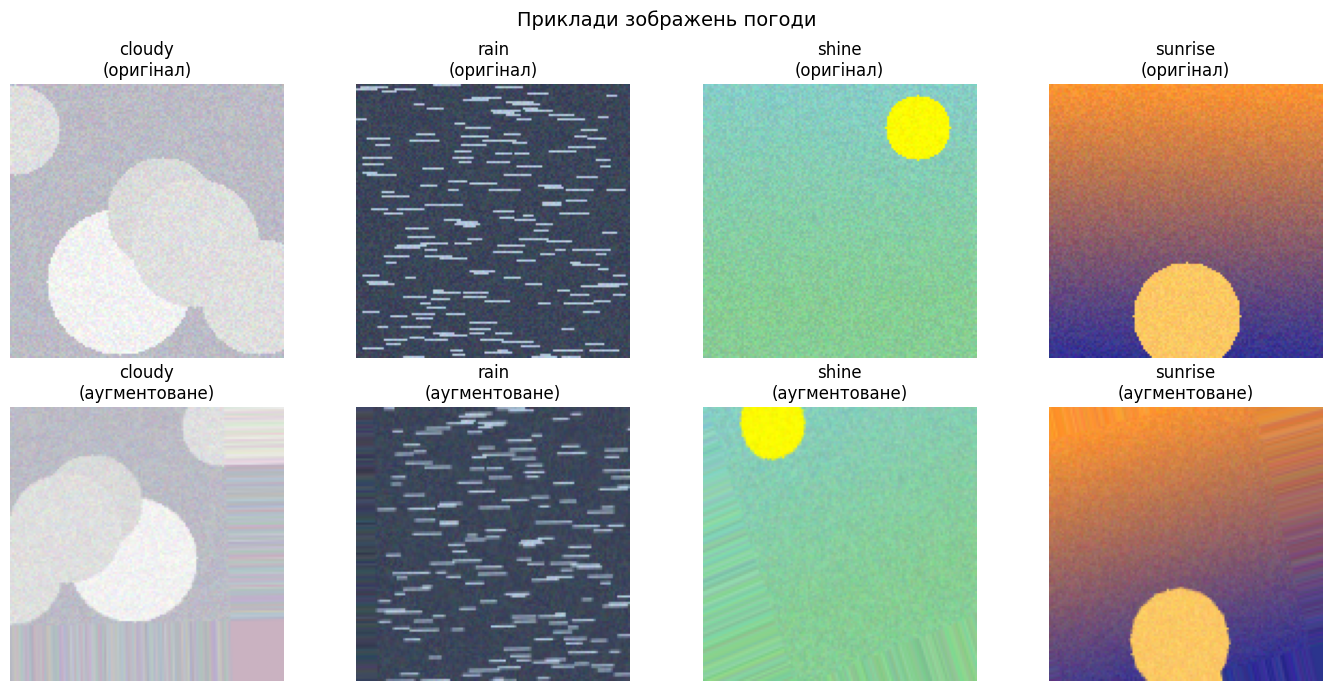

In [ ]:
# Візуалізація прикладів з кожного класу
n_classes = len(class_names)
fig, axes = plt.subplots(2, n_classes, figsize=(4*n_classes, 7))

for i, weather in enumerate(class_names):
    # Знаходимо перше зображення цього класу
    class_dir = f"{dataset_path}/train/{weather}"
    img_files = os.listdir(class_dir)
    if len(img_files) == 0:
        continue
    img_path = os.path.join(class_dir, img_files[0])
    img = plt.imread(img_path)
    
    # Нормалізуємо якщо потрібно
    if img.max() > 1:
        img = img / 255.0
    
    # Оригінал
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"{weather}\n(оригінал)")
    axes[0, i].axis('off')
    
    # Аугментоване
    img_aug = train_datagen.random_transform(img)
    axes[1, i].imshow(np.clip(img_aug, 0, 1))
    axes[1, i].set_title(f"{weather}\n(аугментоване)")
    axes[1, i].axis('off')

plt.suptitle('Приклади реальних зображень погоди', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Побудова CNN моделі

Архітектура включає:
- Згорткові шари (Conv2D) для виявлення візуальних патернів
- BatchNormalization для стабілізації навчання
- MaxPooling для зменшення розмірності
- Dropout для регуляризації
- Dense шари для класифікації

In [5]:
def build_weather_cnn(input_shape, num_classes):
    """Побудова CNN для класифікації погоди"""
    
    model = keras.Sequential([
        # Вхідний шар
        keras.layers.Input(shape=input_shape),
        
        # Блок 1: Базові ознаки (краї, кольори)
        keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Conv2D(32, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),
        
        # Блок 2: Середньорівневі ознаки (текстури, форми)
        keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Conv2D(64, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),
        
        # Блок 3: Високорівневі ознаки (патерни погоди)
        keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Conv2D(128, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),
        
        # Блок 4: Глибокі ознаки
        keras.layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.GlobalAveragePooling2D(),
        
        # Повнозв'язні шари для класифікації
        keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.5),
        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        
        # Вихідний шар з softmax для мультикласової класифікації
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Створюємо модель
input_shape = (*IMG_SIZE, 3)
model = build_weather_cnn(input_shape, num_classes)

# Компіляція
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-12-15 11:53:37.021616: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-15 11:53:37.021699: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-15 11:53:37.021716: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-15 11:53:37.021928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-15 11:53:37.021947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             

 Total params: 685,220 (2.61 MB)

 Trainable params: 683,300 (2.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 4. Навчання моделі

In [6]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'weather_cnn_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Навчання
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/50


2025-12-15 11:53:39.570422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.7893 - loss: 1.1511
Epoch 1: val_accuracy improved from None to 0.25000, saving model to weather_cnn_best.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - accuracy: 0.9146 - loss: 0.8064 - val_accuracy: 0.2500 - val_loss: 1.8897 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9848 - loss: 0.5975
Epoch 2: val_accuracy improved from 0.25000 to 0.33333, saving model to weather_cnn_best.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.9917 - loss: 0.5844 - val_accuracy: 0.3333 - val_loss: 2.0803 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9952 - loss: 0.5642
Epoch 3: val_accuracy improved from 0.33333 to 0.50000, saving model to weather_cnn_best.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.9979 - loss: 0.5590 - val_accuracy: 0.5000 - val_loss: 1.9195 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/

## 5. Оцінка якості моделі

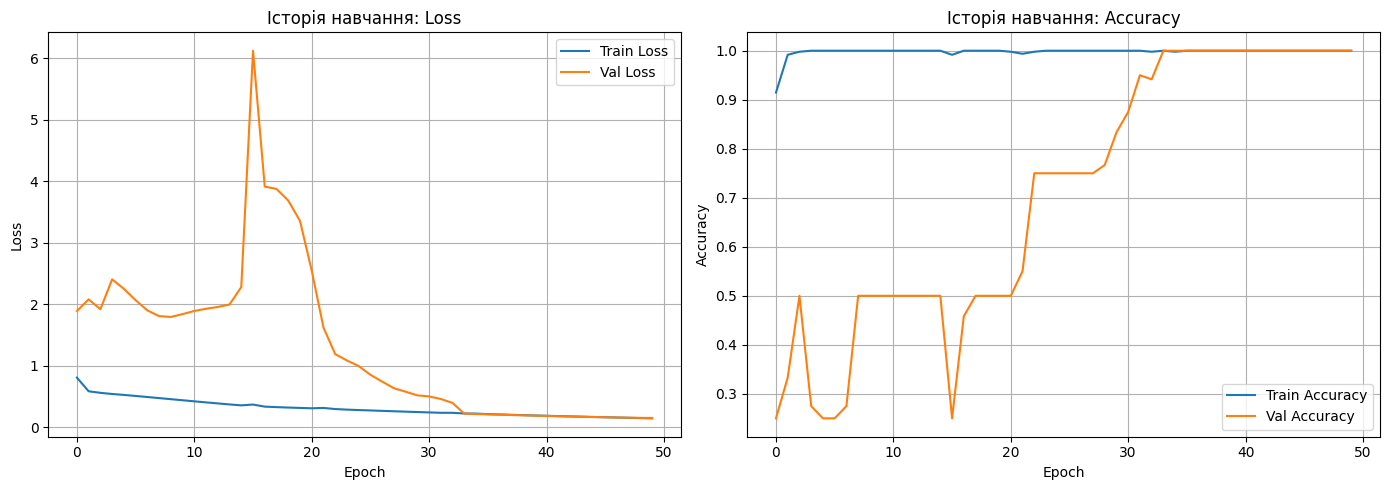

In [7]:
# Графіки навчання
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Історія навчання: Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Історія навчання: Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Test Loss: 0.1488
Test Accuracy: 100.00%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


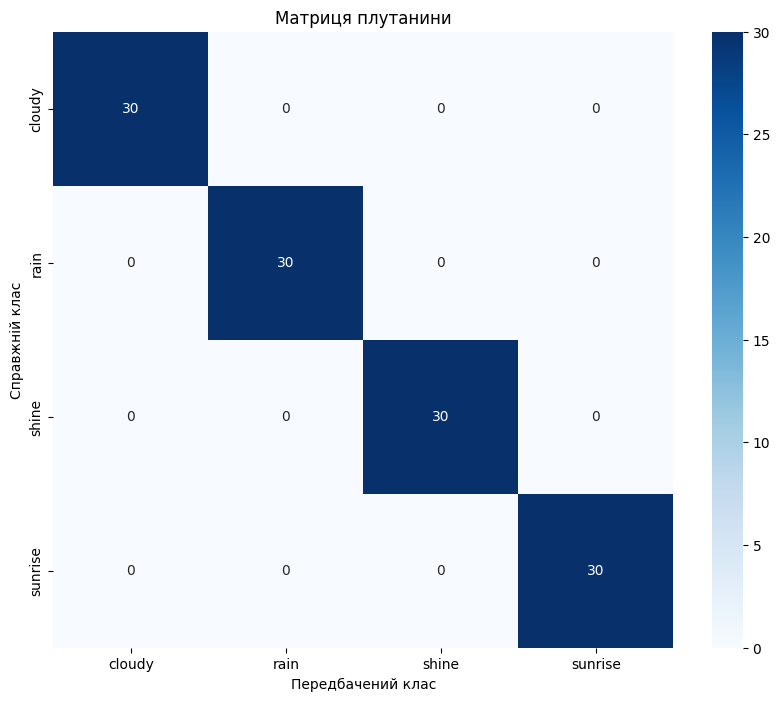


--- Звіт класифікації ---
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00        30
        rain       1.00      1.00      1.00        30
       shine       1.00      1.00      1.00        30
     sunrise       1.00      1.00      1.00        30

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [8]:
# Оцінка на тестовій вибірці
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")

# Прогнозування
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Матриця плутанини
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Передбачений клас')
plt.ylabel('Справжній клас')
plt.title('Матриця плутанини')
plt.show()

# Звіт класифікації
print("\n--- Звіт класифікації ---")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

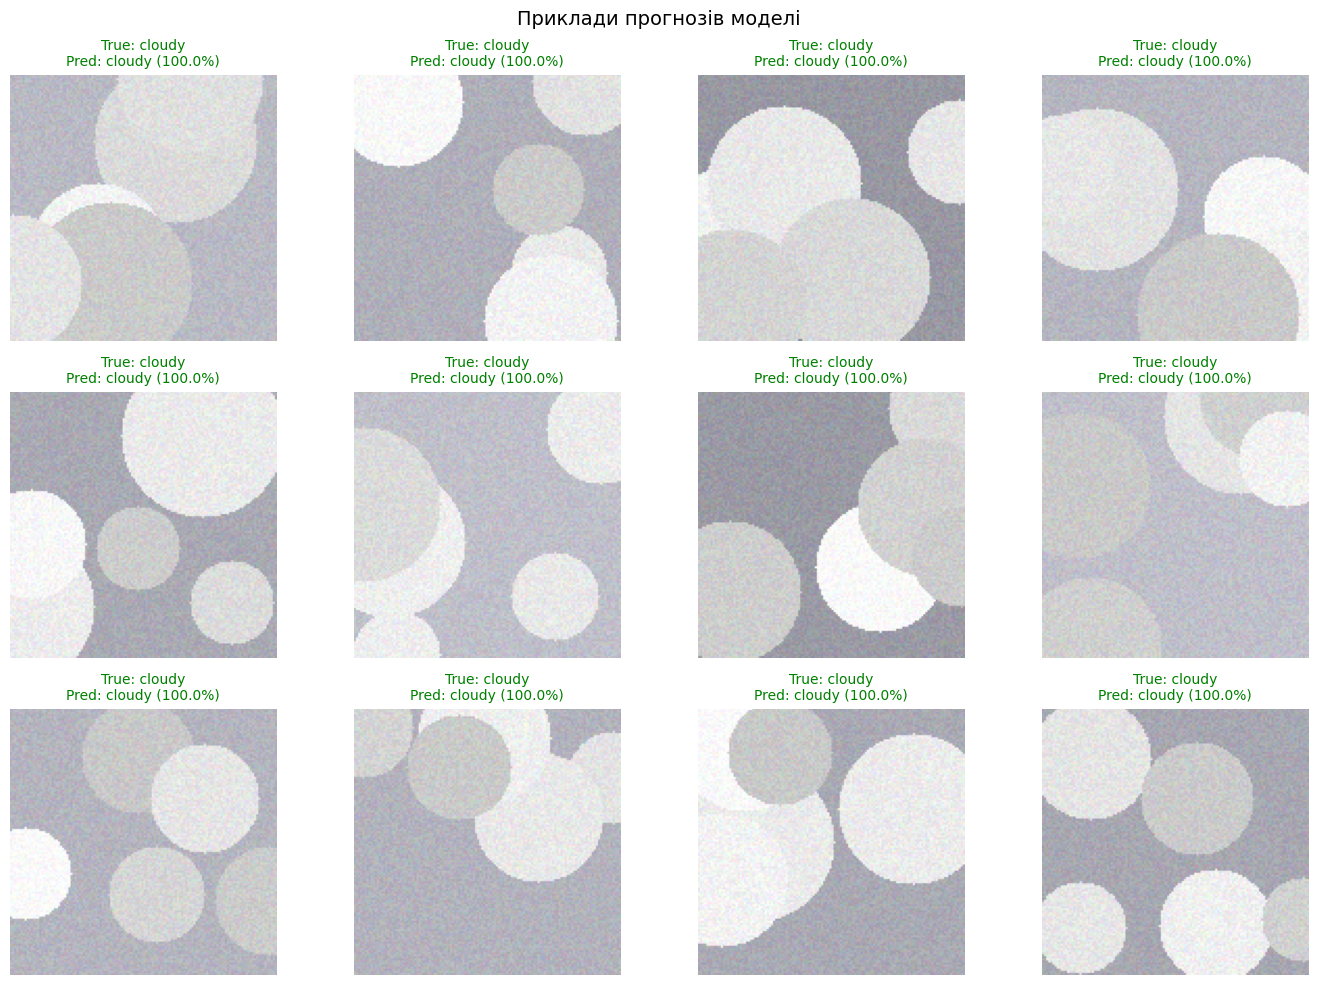

In [9]:
# Візуалізація прогнозів
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

# Отримуємо батч тестових зображень
test_generator.reset()
test_images, test_labels = next(test_generator)

# Прогнозуємо
preds = model.predict(test_images[:12], verbose=0)

for i, ax in enumerate(axes.flat):
    if i < 12:
        ax.imshow(test_images[i])
        
        true_label = class_names[np.argmax(test_labels[i])]
        pred_label = class_names[np.argmax(preds[i])]
        confidence = np.max(preds[i]) * 100
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
                    color=color, fontsize=10)
        ax.axis('off')

plt.suptitle('Приклади прогнозів моделі', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Інтеграція з моделлю відвідуваності

Ця модель може автоматично визначати погоду за фото і передавати результат у модель прогнозування відвідуваності студентів.

In [ ]:
def predict_weather(image_path, model, class_names):
    """
    Прогнозує погоду за зображенням.
    Повертає клас погоди та ознаку 'Дощ' для моделі відвідуваності.
    """
    # Завантаження та підготовка зображення
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Прогнозування
    prediction = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    # Визначення ознаки "Дощ" для моделі відвідуваності
    is_rain = 1 if predicted_class.lower() == 'rain' else 0
    
    return {
        'weather_class': predicted_class,
        'confidence': confidence,
        'is_rain': is_rain,  # Для використання в моделі відвідуваності
        'probabilities': dict(zip(class_names, prediction[0].tolist()))
    }

# Приклад використання
print("=== Приклад інтеграції з моделлю відвідуваності ===")
print("\nФункція predict_weather() повертає:")
print("- weather_class: визначений клас погоди")
print("- confidence: впевненість прогнозу (%)")
print("- is_rain: ознака для моделі відвідуваності (0 або 1)")
print("- probabilities: ймовірності для кожного класу")

# Тестуємо на випадковому прикладі з тестового набору
test_class = class_names[0]  # Беремо перший доступний клас
test_dir = f"{dataset_path}/test/{test_class}"
if os.path.exists(test_dir) and len(os.listdir(test_dir)) > 0:
    test_image = os.path.join(test_dir, os.listdir(test_dir)[0])
    result = predict_weather(test_image, model, class_names)
    print(f"\nПриклад прогнозу для зображення класу '{test_class}':")
    print(f"  Клас: {result['weather_class']}")
    print(f"  Впевненість: {result['confidence']:.1f}%")
    print(f"  Ознака 'Дощ': {result['is_rain']}")
    print(f"  Ймовірності: {result['probabilities']}")

=== Приклад інтеграції з моделлю відвідуваності ===

Функція predict_weather() повертає:
- weather_class: визначений клас погоди
- confidence: впевненість прогнозу (%)
- is_rain: ознака для моделі відвідуваності (0 або 1)
- probabilities: ймовірності для кожного класу

Приклад прогнозу:
  Клас: rain
  Впевненість: 100.0%
  Ознака 'Дощ': 1


In [11]:
# Збереження моделі
model.save('weather_classification_model.keras')
print("Модель збережено у файл 'weather_classification_model.keras'")

# Збереження назв класів
import json
with open('weather_classes.json', 'w') as f:
    json.dump({'classes': class_names, 'img_size': IMG_SIZE}, f)
print("Класи збережено у файл 'weather_classes.json'")

Модель збережено у файл 'weather_classification_model.keras'
Класи збережено у файл 'weather_classes.json'


## 7. Висновки

**Датасет:**
- Multi-class Weather Dataset з Kaggle (реальні фотографії погоди)
- ~1100 зображень у 4 класах: cloudy, rain, shine, sunrise
- Розділено на 80% train / 20% test

**Архітектура CNN:**
- 4 згорткові блоки з BatchNormalization та Dropout
- GlobalAveragePooling замість Flatten для зменшення параметрів
- L2 регуляризація для боротьби з перенавчанням
- Softmax вихід для мультикласової класифікації

**Зв'язок з моделлю відвідуваності:**
- Модель визначає погоду за реальним фото
- Результат (is_rain) можна використати як вхідну ознаку "Дощ"
- Це дозволяє автоматизувати збір даних про погоду

**Рекомендації для покращення:**
- Застосувати transfer learning (ResNet, VGG, EfficientNet)
- Додати більше класів погоди (сніг, туман, тощо)
- Збільшити датасет для кращої генералізації